Prevendo doadores de sangue

Dados de Taiwan
https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

In [18]:
# Import pandas
import pandas as pd

# Lendo o  dataset
transfusao = pd.read_csv("Transfusao.csv")


transfusao.head()


,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0



* Recency - meses da ultima doação
* Frequency - total de doações
* Monetary - total de sangue doado ($)
* Time - meses desde a primeira doação
* variável binária se a pessoa doou sangue em Março de 2007 (1 SIM; 0 NÃO)

In [19]:
transfusao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


Criando a coluna alvo

In [20]:
transfusao.rename(
    columns={"whether he/she donated blood in March 2007": "target"},
    inplace=True
)

transfusion.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1


Verificando incidência do alvo:

* 0 - não doará sangue;
* 1 - doará sangue;

In [21]:
transfusao.target.value_counts(normalize=True).round(3)

0    0.762
1    0.238
Name: target, dtype: float64

Dividindo em treino e teste

In [22]:

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    transfusao.drop(columns='target'),
    transfusao.target,
    test_size=0.25,
    random_state=42,
    stratify=transfusao.target
)


X_train.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
334,16,2,500,16
99,5,7,1750,26


Modelo TPOT (*Tree-based Pipeline Optimization Tool*)

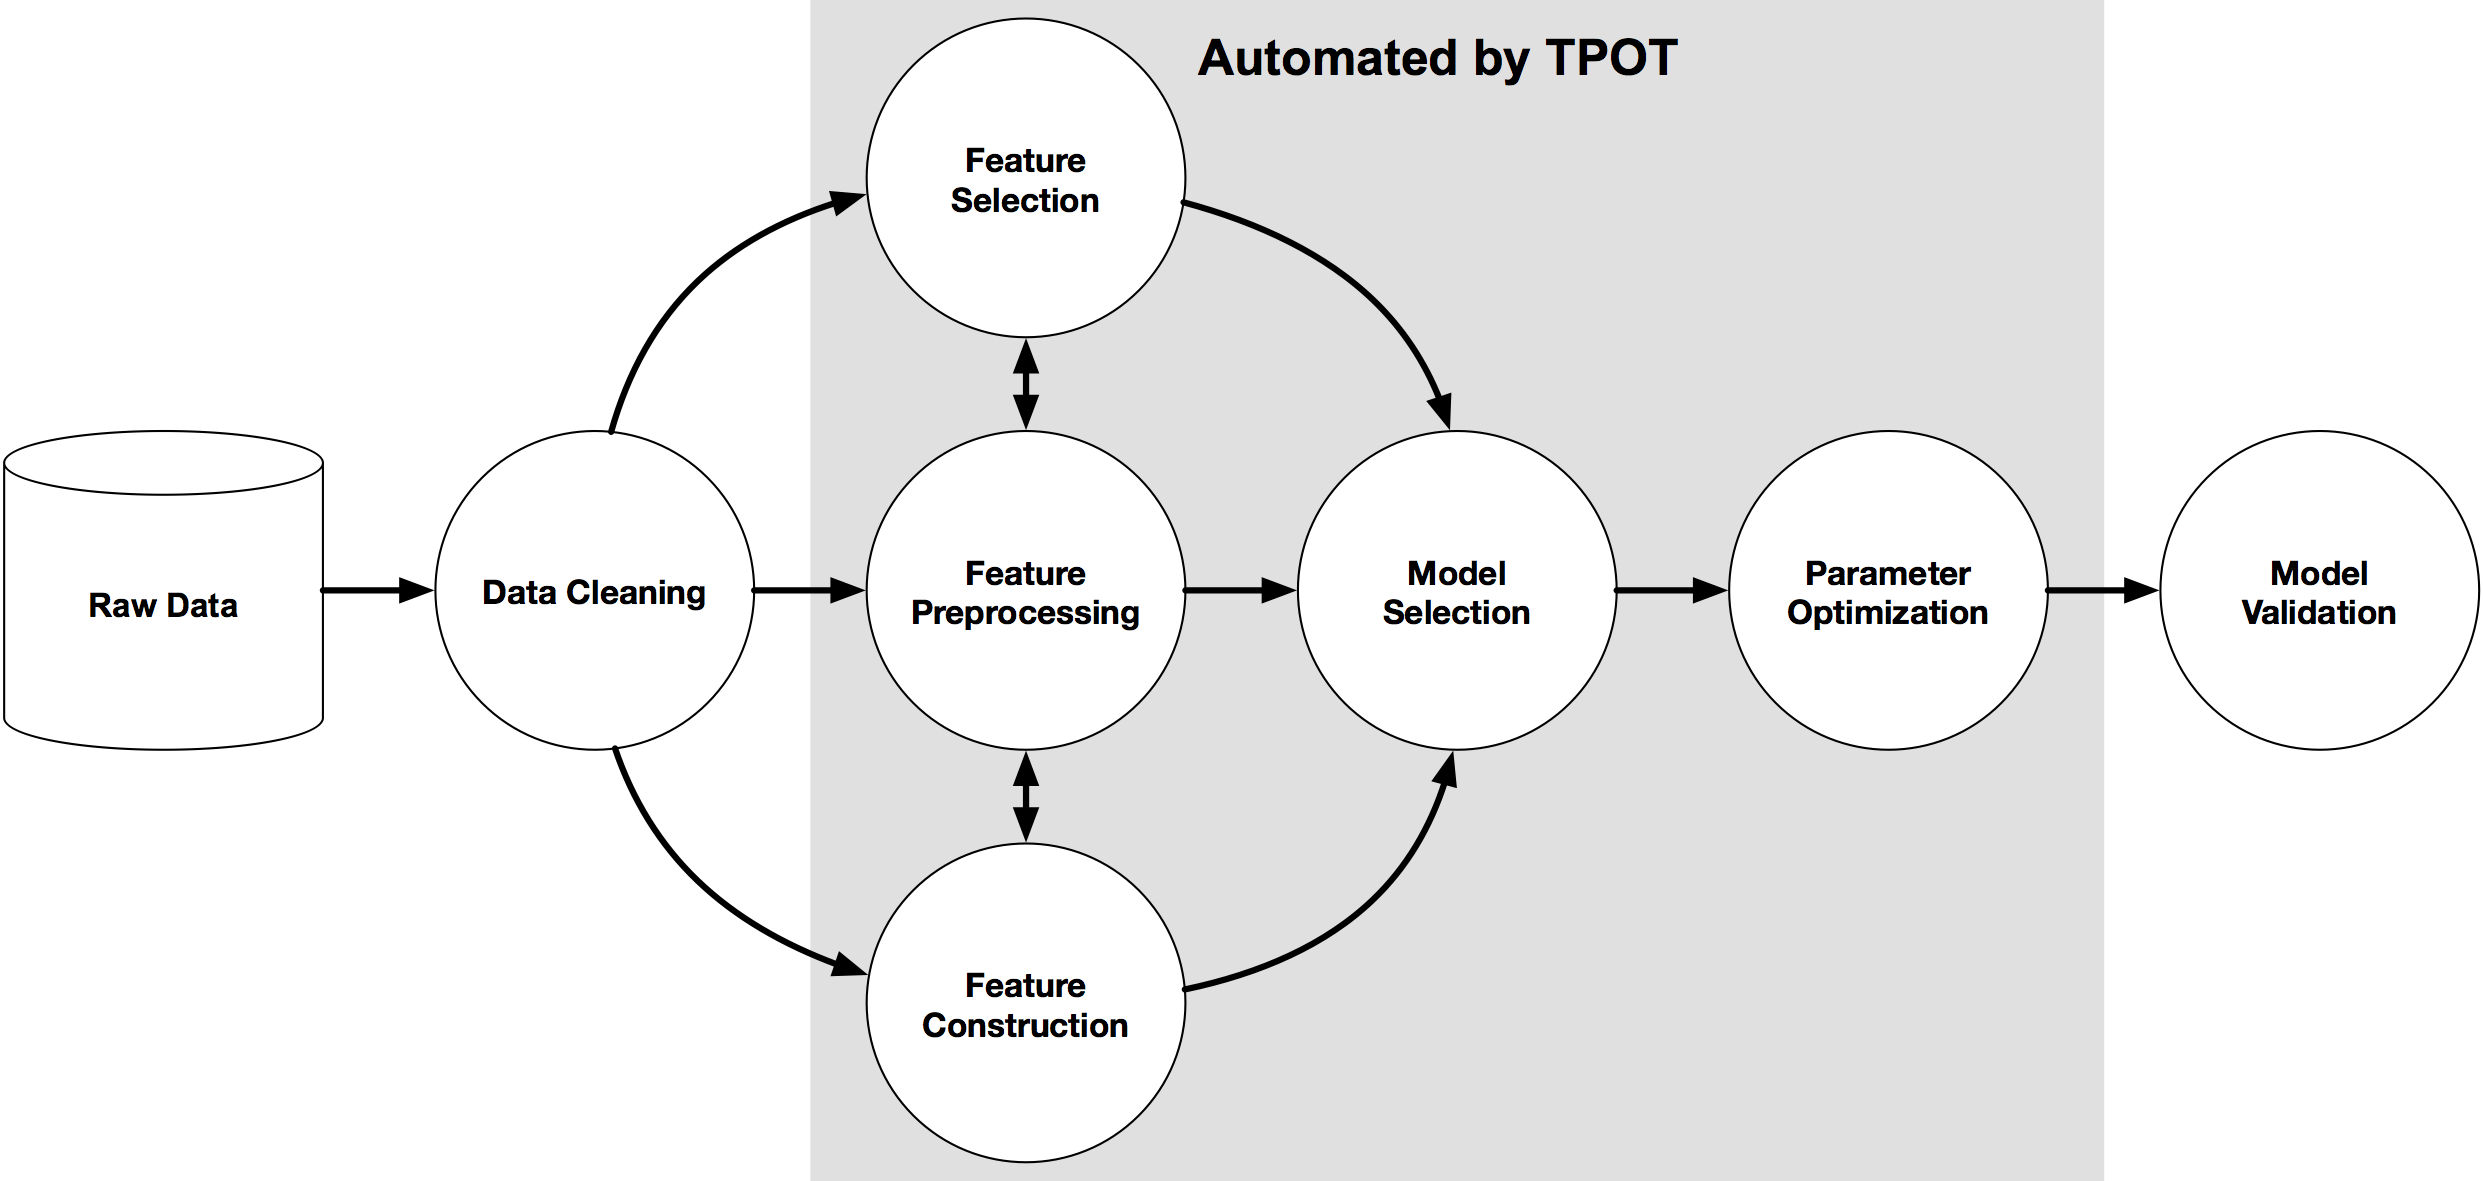

In [23]:
!pip install TPOT

In [24]:

from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score


tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

# AUC score para modelo TPOT
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


print('\nMelhores steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7422459184429089

Generation 2 - Current best internal CV score: 0.7422459184429089

Generation 3 - Current best internal CV score: 0.7422459184429089

Generation 4 - Current best internal CV score: 0.7422459184429089

Generation 5 - Current best internal CV score: 0.7456308339276876

Best pipeline: MultinomialNB(Normalizer(input_matrix, norm=l2), alpha=0.001, fit_prior=True)

AUC score: 0.7637

Melhores steps:
1. Normalizer()
2. MultinomialNB(alpha=0.001)


Verificando a variância

In [25]:
X_train.var().round(3)

Recency (months)              66.929
Frequency (times)             33.830
Monetary (c.c. blood)    2114363.700
Time (months)                611.147
dtype: float64

Normalização

In [26]:
# Import numpy
import numpy as np


X_train_normed, X_test_normed = X_train.copy(), X_test.copy()


col_to_normalize = "Monetary (c.c. blood)"


for df_ in [X_train_normed, X_test_normed]:

    df_['monetary_log'] = np.log(df_[col_to_normalize])

    df_.drop(columns=col_to_normalize, inplace=True)

X_train_normed.var().round(3)

Recency (months)      66.929
Frequency (times)     33.830
Time (months)        611.147
monetary_log           0.837
dtype: float64

In [27]:
# Import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

# Instanciando Multinomial NB
clf = MultinomialNB(alpha=0.001)

# Treinamento
clf.fit(X_train_normed, y_train)

# AUC score para o modelo TPOT
clf_auc_score = roc_auc_score(y_test, clf.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {clf_auc_score:.4f}')


AUC score: 0.7638


In [28]:
# Import Modelo Linear
from sklearn import linear_model

# Instanciando LogisticRegression
logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Treinamento
logreg.fit(X_train_normed, y_train)

# AUC score para o modelo TPOT
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7890
